<a href="https://colab.research.google.com/github/tsuji1234/sample/blob/main/BertByTsuji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip-install
---
* ファイル保存しておいてロード出来るようにする

In [1]:
## =================================================================
## パッケージインストール
## =================================================================
!pip install --upgrade pip
!pip install transformers==4.18.0 fugashi==1.1.0 ipadic==1.0.0 pytorch-lightning==1.6.1
!pip install livelossplot --quiet # acc, lossグラフ表示用


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 482.2/482.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.5/582.5 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 73.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━

# Debug用
---

In [2]:
#import pdb
#pdb.set_trace()

# クラス定義
---

In [3]:
from transformers import BertJapaneseTokenizer
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

## =================================================================
## 名称：BERT関連のオブジェクト生成
## =================================================================
class BertBuilder:
    # =================================================
    # 内容：コンストラクタ
    # 入力：GPU                   True:gpuあり、False:なし
    # 戻値：なし
    # =================================================
    def __init__(self, GPU=True, batch_size=16, max_token=256, max_epochs=5):
        self.GPU = GPU
        self.batch_size = batch_size
        self.max_token = max_token
        self.max_epochs = max_epochs

    # =================================================
    # 内容：分類用の事前学習モデルを作成
    # 入力：viewer                学習状況表示用
    # 戻値：model                 事前学習モデル
    # =================================================
    def makeClassificationModel(self, viewer):
        model = BertForSequenceClassification_pl(MODEL_NAME, num_labels=2, lr=1e-5, labelName='labels', lossViewer=viewer, GPU=self.GPU)
        return model

    # =================================================
    # 内容：入力ファイルをデータローダーに変換
    # 入力：inputDataList         入力データのリスト
    # 戻値：dlTrain, dlVal, dlTest
    # =================================================
    def makeDataLoader(self, inputDataList):
        # トークナイザ定義
        bertTokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
        qaTokenizer = QATokenizer(bertTokenizer, None)

        inputToken = qaTokenizer.tokenizer(inputDataList, max_length=self.max_token)
        dlTrain, dlVal, dlTest = DataLoaderConverter(self.batch_size).convert(inputToken)

        self.__printInData(dlTrain)
        return [dlTrain, dlVal, dlTest]

    # =================================================
    # 内容：トレーナー作成
    # 入力：modelDir              モデル出力先フォルダ
    # 戻値：trainer, checkPoint
    # =================================================
    def makeTrainer(self, modelDir):
        if self.GPU:
            return TrainerBuilder(self.max_epochs, modelDir).build(-1) # GPUあり
        else:
            return TrainerBuilder(self.max_epochs, modelDir).build(0) # CPUで実行

    # =================================================
    # 内容：計算量のデバッグログ
    # 入力：
    # 戻値：
    # =================================================
    def __printInData(self, dlTrain):
        print('バッチサイズ：{0}、エポック数：{1}、最大トークンサイズ：{2}'.format(self.batch_size, self.max_epochs, self.max_token))
        print('入力データ：{0}個、1エポック：{1}STEP、合計：{2}STEP'.format(len(dlTrain.dataset),
                                                                            (len(dlTrain.dataset) / self.batch_size),
                                                                            ((len(dlTrain.dataset) / self.batch_size) * self.max_epochs)))


In [4]:
## =================================================================
## PyTorch Lightningの定義
## =================================================================
import torch
import pytorch_lightning as pl
from transformers import BertForSequenceClassification

class BertForSequenceClassification_pl(pl.LightningModule):
    # ===========================================================
    # 名称：コンストラクタ
    # 引数：model_name		 Transformersのモデルの名前
    #       num_labels		ラベルの数
    #       lr				学習率
    # ===========================================================
    def __init__(self, model_name, num_labels, lr, labelName, lossViewer=None, GPU=True):
        super().__init__()
        self.save_hyperparameters()		## 以降、self.hparamsでnum_labelsとlrにアクセス出来る
        # BERTのロード
        self.bert_sc = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        if GPU == True:
            self.bert_sc = self.bert_sc.cuda() # コンストラクタで実行する必要がありそう。
        # Viewer設定
        self.lossViewer = lossViewer
        if lossViewer == None:
            lossViewer = NullViewer()
        pass

    # 学習データのミニバッチ(`batch`)が与えられた時に損失を出力する関数を書く。
    # batch_idxはミニバッチの番号であるが今回は使わない。
    def training_step(self, batch, batch_idx):
        output = self.bert_sc(**batch)
        loss = output.loss
        self.log('train_loss', loss) # 損失を'train_loss'の名前でログをとる。
        self.lossViewer.setLoss(loss)
        return loss

    # 検証データのミニバッチが与えられた時に、
    # 検証データを評価する指標を計算する関数を書く。
    def validation_step(self, batch, batch_idx):
        output = self.bert_sc(**batch)
        val_loss = output.loss
        self.log('val_loss', val_loss) # 損失を'val_loss'の名前でログをとる。
        self.lossViewer.setValLoss(val_loss)

    # テストデータのミニバッチが与えられた時に、
    # テストデータを評価する指標を計算する関数を書く。
    def test_step(self, batch, batch_idx):
        labels = batch.pop(self.hparams.labelName) # バッチからラベルを取得
        output = self.bert_sc(**batch)
        labels_predicted = output.logits.argmax(-1)
        num_correct = ( labels_predicted == labels ).sum().item()
        accuracy = num_correct/labels.size(0) #精度
        self.log('accuracy', accuracy) # 精度を'accuracy'の名前でログをとる。

    # 学習に用いるオプティマイザを返す関数を書く。
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [5]:
import csv
import glob
import os

## =================================================================
## 名称：CSV読込みクラス
## =================================================================
class csvLoader:
    # ========================
    # コンストラクタ
    # dirPath : 入力CSVが入っているフォルダパス
    # hdr_skip      True :CSVの1行目をスキップする
    #               False:CSVの1行目スキップをしない
    # ========================
    def __init__(self, dirPath, hdr_skip=False):
        self.dirPath = dirPath
        self.hdr_skip = hdr_skip

    # ========================
    # 名称：CSVファイル読込み
    # 説明：CSVを読み込んで二次元リストを返す
    # 戻値：二次元リスト
    # ========================
    def load(self):
        chkFile = os.path.join(self.dirPath, "*.csv")
        schFileList = glob.glob(chkFile)

        retList = []
        for fPath in schFileList:
            print('read file : {0}'.format(fPath))
            with open(fPath, 'r', encoding = 'shift_jis', errors = 'ignore') as f:
                reader = csv.reader(f)
                if self.hdr_skip == True : next(reader) # ヘッダースキップ
                for line in reader:
                    retList.append(line)
        return retList


In [6]:
import torch
import random
from torch.utils.data import DataLoader

## =================================================================
## 名称：トークンデータをDataLoaderに変換する
## =================================================================
class DataLoaderConverter:
    # ========================
    # コンストラクタ
    # inputLoader      入力データロード用クラスインスタンス
    #                  load()メソッドを実装している
    # ========================
    def __init__(self, batchSize):
        self.batchSize = batchSize

    def convert(self, inputToken):
        tensorList = self.__convertTensor(inputToken)	# torchで扱える形式に変換
        dsTrain, dsVal, dsTest = self.__dataSplit(tensorList)
        print('トレーニングデータ:{0}、検証データ:{1}、テストデータ:{2}、合計:{3}'.format(len(dsTrain), len(dsVal), len(dsTest), len(tensorList)))

        # データセットからデータローダを作成
        # 学習データはshuffle=Trueにする。
        dataloader_train = DataLoader(dsTrain, batch_size=self.batchSize, shuffle=True)
        dataloader_val   = DataLoader(dsVal,   batch_size=256)
        dataloader_test  = DataLoader(dsTest,  batch_size=256)
        return [dataloader_train, dataloader_val, dataloader_test]

    ## データセット分割
    def __dataSplit(self, tensorList):
        random.shuffle(tensorList) # ランダムにシャッフル
        n = len(tensorList)
        n_train = int(0.6*n)
        n_val = int(0.2*n)
        dataset_train = tensorList[:n_train]				# 学習データ(0 ～ MAX*0.6)
        dataset_val = tensorList[n_train:n_train+n_val]		# 検証データ(MAX*0.6 ～ MAX*0.8)
        dataset_test = tensorList[n_train+n_val:]			# テストデータ(MAX*0.8 ～ MAX)
        return [dataset_train, dataset_val, dataset_test]

    ## torchで扱える形式に変換
    def __convertTensor(self, input):
        encodingList = []
        for line in input:
            encoding = { k: torch.tensor(v) for k, v in line.items() }
            encodingList.append(encoding)
        return encodingList



In [14]:
import os
import shutil
import datetime

## =================================================================
## 名称：フォルダ操作
## =================================================================
class DirController:
    def __init__(self):
        pass

    ## 削除してフォルダ作成
    def clearDir(self, dir_path):
        if os.path.exists(modelDir):
            shutil.rmtree(modelDir)
        os.mkdir(modelDir)
        pass

    ## リネームしてフォルダ作成
    def clearBackupDir(self, dir_path):
        # 現在時刻をフォルダ名に付与してリネーム
        if os.path.exists(dir_path):
            now_str = datetime.datetime.now().strftime('_%Y%m%d%H%M')
            os.rename(dir_path, dir_path + now_str)

        # フォルダ作成
        os.makedirs(dir_path)
        pass


In [8]:
## =================================================================
## 名称：処理機カテゴライズ用のtokenizer
## =================================================================
class QATokenizer:
    # ========================
    # コンストラクタ
    # inputLoader      入力データロード用クラスインスタンス
    #                  load()メソッドを実装している
    # ========================
    def __init__(self, bertTokenizer, inputLoader):
        self.bertTokenizer = bertTokenizer
        self.inputLoader = inputLoader

    # ========================
    # トークン化
    # inputDataList    二次元リスト
    # ========================
    def tokenizer(self, inputDataList, max_length=512):
        retList = []
        for line in inputDataList:
            text = line[0]
            label = line[2]

            encoding = self.bertTokenizer(text, max_length = max_length, padding = 'max_length', truncation = True)
            encoding['labels'] = 0 if label == 'IMBT' else 1
            retList.append(encoding)

        return retList


In [9]:
import pytorch_lightning as pl

## =================================================================
## 名称：トレーニング用のインスタンス作成
## =================================================================
class TrainerBuilder:
    # ========================
    # コンストラクタ
    # ========================
    def __init__(self, epochs, modelTempPath):
        self.epochs = epochs
        self.modelTempPath = modelTempPath
        pass

    def build(self, gpus):
        # 学習時にモデルの重みを保存する条件を指定
        checkpoint = pl.callbacks.ModelCheckpoint(
            monitor = 'val_loss',
            mode = 'min',
            save_top_k = 1,
            save_weights_only = True,
            dirpath = self.modelTempPath,
            )

        # 学習の方法を指定
        trainer = pl.Trainer(
            gpus = gpus,                 # 使用GPU
            val_check_interval = 0.5,    # トレーニング中の検証呼出し率
            max_epochs = self.epochs,    # エポック数
            callbacks = [checkpoint]
            )

        return [trainer, checkpoint]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from livelossplot import PlotLosses

## =================================================================
## 名称：学習状況の表示
## =================================================================
class trainViewer:
    # ========================
    # コンストラクタ
    # ========================
    def __init__(self):
        self.loss = []
        self.val_loss = []
        self.liveloss = PlotLosses()

    def setLoss(self, loss):
        self.loss.append(loss)
        logs = {}
        logs['loss'] = loss.detach().cpu()
        self.liveloss.update(logs)
        self.liveloss.send()

    def setValLoss(self, val_loss):
        self.val_loss.append(val_loss)
        logs = {}
        logs['val_loss'] = val_loss.detach().cpu()
        self.liveloss.update(logs)
        self.liveloss.send()


class trainLogger:
    # ========================
    # コンストラクタ
    # ========================
    def __init__(self):
        self.loss = []
        self.val_loss = []
        self.liveloss = PlotLosses()

    def setLoss(self, loss):
        self.loss.append(loss)
        print('loss : {0}'.format(loss))

    def setValLoss(self, val_loss):
        self.val_loss.append(val_loss)
        print('val_loss : {0}'.format(val_loss))


## Null Object
class NullViewer:
    def setLoss(loss):
        pass
    def setValLoss(val_loss):
        pass


# 学習処理メイン
---

In [11]:
## =================================================================
## Googleドライブをマウント
## =================================================================
from google.colab import drive
drive.mount('/content/drive')
workDirPath = '/content/drive/MyDrive/SoftmBert'


Mounted at /content/drive


In [15]:
## =================================================================
## データ作成
## =================================================================
import os

## 学習状態表示ビューアを定義
plotViewer = trainViewer()

## BERTクラス分類用プレモデル生成
builder = BertBuilder(GPU=True, batch_size=16, max_token=256, max_epochs=1)
preModel = builder.makeClassificationModel(plotViewer)

## ファイルロード
inputLoader = csvLoader(os.path.join(workDirPath, 'Data'), True)
inputData = inputLoader.load()
#inputData = QATokenizer(bertTokenizer, inputLoader).loadData()
inputData = inputData[0:1000]

## DataLoader作成
dlTrain, dlVal, dlTest = builder.makeDataLoader(inputData)

## トレーナー作成
modelDir = os.path.join(workDirPath, 'Model/')
trainer, checkPoint = builder.makeTrainer(modelDir)


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

read file : /content/drive/MyDrive/SoftmBert/Data/202109.csv
read file : /content/drive/MyDrive/SoftmBert/Data/202107.csv
read file : /content/drive/MyDrive/SoftmBert/Data/202106.csv
read file : /content/drive/MyDrive/SoftmBert/Data/202105.csv
read file : /content/drive/MyDrive/SoftmBert/Data/202203.csv
read file : /content/drive/MyDrive/SoftmBert/Data/202111.csv
read file : /content/drive/MyDrive/SoftmBert/Data/202202.csv
read file : /content/drive/MyDrive/SoftmBert/Data/202110.csv
read file : /content/drive/MyDrive/SoftmBert/Data/202201.csv
read file : /content/drive/MyDrive/SoftmBert/Data/202108.csv
read file : /content/drive/MyDrive/SoftmBert/Data/202104.csv
read file : /content/drive/MyDrive/SoftmBert/Data/202112.csv


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


トレーニングデータ:600、検証データ:200、テストデータ:200、合計:1000
バッチサイズ：16、エポック数：1、最大トークンサイズ：256
入力データ：600個、1エポック：37.5STEP、合計：37.5STEP


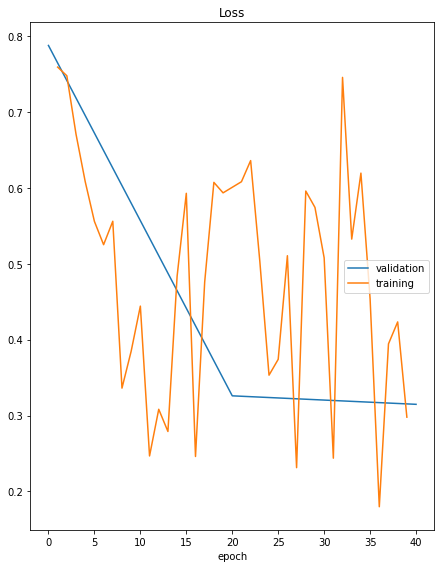

Loss
	validation       	 (min:    0.315, max:    0.788, cur:    0.315)
	training         	 (min:    0.180, max:    0.759, cur:    0.298)


In [16]:
## =================================================================
## ファインチューニング
## =================================================================
# ディレクトリを空にする
DirController().clearDir(modelDir)

## fit
trainer.fit(preModel, dlTrain, dlVal)


In [17]:
## =================================================================
## 結果の評価
## =================================================================
print('ベストモデルのファイル: ', checkPoint.best_model_path)
print('ベストモデルの検証データに対する損失: ', checkPoint.best_model_score)

# チューニング済みモデルをロード
tuneModel = preModel.load_from_checkpoint(checkPoint.best_model_path)

# 評価実施
testResult = trainer.test(tuneModel, dlTest)
print(f'Accuracy: {testResult[0]["accuracy"]:.2f}')


ベストモデルのファイル:  /content/drive/MyDrive/SoftmBert/Model/epoch=0-step=38.ckpt
ベストモデルの検証データに対する損失:  tensor(0.3148, device='cuda:0')


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.8349999785423279     │
└───────────────────────────┴───────────────────────────┘

Accuracy: 0.83


In [18]:
## =================================================================
## モデル保存
## =================================================================
# フォルダを空にする
resultDirPath = os.path.join(workDirPath, 'Result')
DirController().clearDir(resultDirPath)

# 保存
saveDirectory = os.path.join(resultDirPath, 'model_transformers')
tuneModel.bert_sc.save_pretrained( saveDirectory )
print('チューニング済みモデル保存先：', saveDirectory)


チューニング済みモデル保存先： /content/drive/MyDrive/SoftmBert/Result/model_transformers
